In [1]:
import pandas as pd
import ast
from data import data

from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline
pd.options.display.max_rows = 500

In [2]:
books = data.loadAndClean('../booksummaries/booksummaries.txt')

In [3]:
books = books[['bookGenre', 'plotSum', 'bookTitle']]

In [4]:
corpus = list(books.bookGenre.apply(lambda row: ' '.join(row)))
corpus[:3]

['roman_à_clef satire childrens_literature speculative_fiction fiction',
 'science_fiction novella speculative_fiction utopian_and_dystopian_fiction satire fiction',
 'existentialism fiction absurdist_fiction novel']

My corpus is a set of documents. In this case, each document is a string where terms are genres.

In [5]:
# Create a CountVectorizer function contained within a variable
vectorizer = CountVectorizer()

# Tell this vectorizer model to fit itself to my corpus
X = vectorizer.fit_transform(corpus)

# Check the shape of my new object I have created.
# This object will have a row for every document in my corpus,\
# and a column for all of the vocabulary words in my corpus
X.toarray().shape

(12841, 234)

We see we have 12841 rows representing 12481 documents, and 234 'words' in our vocabulary. 
Each value will be a count of how many times the document contains this word.

In [6]:
# Now we want a symmetric correlation matrix showing how often the genres appeared with each other.
Xc = (X.T * X)
Xc.setdiag(0)
co_occurences = pd.DataFrame(Xc.toarray())
co_occurences.columns = vectorizer.get_feature_names()
co_occurences.index = vectorizer.get_feature_names()

In [7]:
co_occurences.iloc[:5,:5]

,absurdist_fiction,adventure,adventure_novel,albino_bias,alien_invasion
absurdist_fiction,0,2,2,0,0
adventure,2,0,20,0,0
adventure_novel,2,20,0,0,0
albino_bias,0,0,0,0,0
alien_invasion,0,0,0,0,0


This little snippet shows our symmetric co_occurence count matrix. 

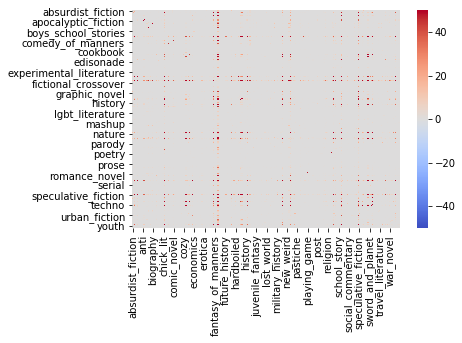

In [8]:
sns.heatmap(co_occurences, vmin=-50, vmax=50, cmap='coolwarm')

This heatmap isn't very useful b/c of how many genres we have.

In [9]:
# Transform our data frame to have the first column be called genre_1
co_occurences = co_occurences.reset_index().rename(columns={"index": "genre_1"})
# Go from this symmetric co_occurence matrix back to a Pandas.DataFrame\
# and rename our columns for easier reading
co_occurences = pd.melt(co_occurences, id_vars=['genre_1'], value_vars=co_occurences.columns[1:])
co_occurences.columns=['genre_1','genre_2','co_occurence_num']
co_occurences['genrePair'] = co_occurences.apply(lambda row: ', '.join(sorted([row.genre_1, row.genre_2])), axis=1)
co_occurences = co_occurences.drop_duplicates(subset='genrePair')
co_occurences = co_occurences[['genrePair', 'co_occurence_num']]

# Turn the genrePair strings back into a list so we can
# compare them directly with our books['bookGenre'] lists 
co_occurences['genrePair'] = co_occurences['genrePair'].apply(lambda row: row.split(','))

In [10]:
co_occurences.sort_values(by='co_occurence_num', ascending=False).iloc[0:10,]

,genrePair,co_occurence_num
43020,"[science_fiction, speculative_fiction]",2014
17748,"[fiction, speculative_fiction]",1997
16812,"[fantasy, speculative_fiction]",1675
6627,"[childrens_literature, fiction]",1123
17733,"[fiction, science_fiction]",1093
16689,"[fantasy, fiction]",1045
17688,"[fiction, novel]",1025
17681,"[fiction, mystery]",853
6750,"[childrens_literature, speculative_fiction]",821
17756,"[fiction, suspense]",714


We see that 'speculative_fiction' and 'science_fiction' appear together in 2014 separate documents.
These types of insights will help us make the rules to classify our multi-genre labels into a single genre. 

In [11]:
# Sort all the bookGenre lists so we can compare them directly with our co_occurences lists 
books['bookGenre'] = books['bookGenre'].apply(lambda row: sorted(row))